In [ ]:
reset -fs

In [ ]:
import numpy as np
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, GlobalAveragePooling2D, InputLayer, Dropout, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras.models import Model

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='') #no need to assign tpu name on Google Colab
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

# To use TPU:
"""
strategy = tf.distribute.TPUStrategy(resolver)

with strategy.scope():
    model.add(...)
"""

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.96.110.90:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.96.110.90:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]


In [ ]:
print("Num TPUs Available: ", len(tf.config.list_logical_devices('TPU')))

Num TPUs Available:  8


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
datagen = ImageDataGenerator(rescale=1./255)
        #rotation_range=90,
        #width_shift_range=0.1,
        #height_shift_range=0.1,
        #shear_range=0.1,
        #horizontal_flip=True,
        #fill_mode='nearest')

In [ ]:
train_generator = datagen.flow_from_directory(
        'drive/MyDrive/human_1/train',  
        target_size=(224, 224), 
        batch_size=32,
        seed=11,
        shuffle=False,
        color_mode='rgb',
        class_mode='binary') 

Found 4352 images belonging to 2 classes.


In [ ]:
val_generator = datagen.flow_from_directory(
        'drive/MyDrive/human_1/val',  
        target_size=(224, 224), 
        batch_size=32,
        seed=11,
        shuffle=False,
        color_mode='rgb',
        class_mode='binary') 

Found 1536 images belonging to 2 classes.


In [ ]:
test_generator = datagen.flow_from_directory(
        'drive/MyDrive/human_1/test',  
        target_size=(224, 224), 
        batch_size=32,
        seed=11,
        shuffle=False,
        color_mode='rgb',
        class_mode='binary') 

Found 1536 images belonging to 2 classes.


In [ ]:
images, labels = next(train_generator)
print(images.shape)
print(labels.shape)

(32, 224, 224, 3)
(32,)


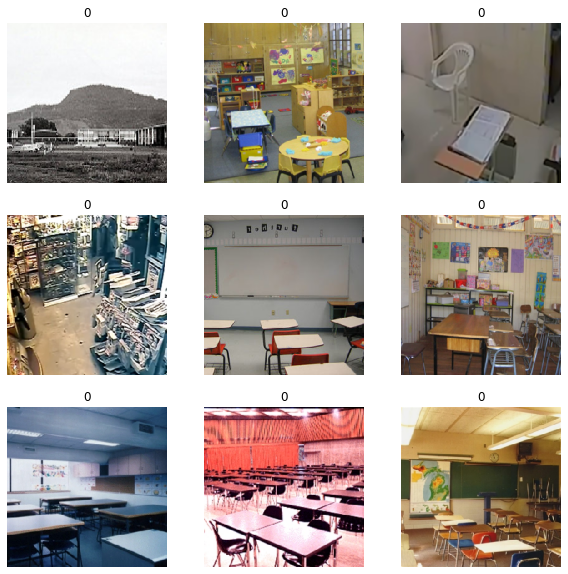

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(int(labels[i]))
    plt.axis("off")

In [ ]:
base_model = mobilenet_v2.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3)) 

for layer in base_model.layers:
    layer.trainable = False    

x = base_model.output

#x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.05)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.05)(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

9420800/9406464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                               

In [ ]:
history = model.fit(train_generator, epochs = 30, verbose=1, validation_data = val_generator,
    callbacks=[
        keras.callbacks.CSVLogger('training.log', separator=',', append=False),
        keras.callbacks.EarlyStopping(patience=6, verbose=1, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(factor=.5, patience=3, verbose=1)
])

Epoch 1/30
136/136 [==============================] - 3065s 23s/step - loss: 0.5984 - accuracy: 0.8187 - val_loss: 1.2468 - val_accuracy: 0.7389 - lr: 1.0000e-04
Epoch 2/30
136/136 [==============================] - 255s 2s/step - loss: 0.2062 - accuracy: 0.9233 - val_loss: 0.1867 - val_accuracy: 0.9414 - lr: 1.0000e-04
Epoch 3/30
136/136 [==============================] - 255s 2s/step - loss: 0.0835 - accuracy: 0.9708 - val_loss: 0.1210 - val_accuracy: 0.9544 - lr: 1.0000e-04
Epoch 4/30
136/136 [==============================] - 254s 2s/step - loss: 0.0303 - accuracy: 0.9892 - val_loss: 0.2068 - val_accuracy: 0.9505 - lr: 1.0000e-04
Epoch 5/30
136/136 [==============================] - 255s 2s/step - loss: 0.0274 - accuracy: 0.9913 - val_loss: 0.1549 - val_accuracy: 0.9557 - lr: 1.0000e-04
Epoch 6/30
136/136 [==============================] - ETA: 0s - loss: 0.0145 - accuracy: 0.9949
Epoch 00006: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
136/136 [=============

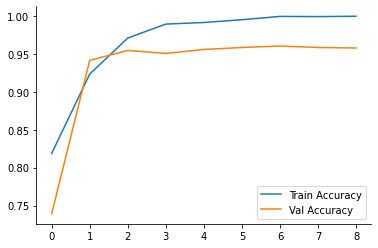

In [ ]:
fig, ax = plt.subplots()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(len(acc))

ax.plot(epochs, acc, label='Train Accuracy')
ax.plot(epochs, val_acc, label='Val Accuracy')

ax.legend()
sns.despine()
plt.savefig("/content/drive/MyDrive/colab/train_val_accuracy_mobilenet_6.png", dpi = 400, facecolor = "w", bbox_inches="tight");

In [ ]:
model.save("/content/drive/MyDrive/colab/model_cnn_mobilenet_6.h5")

In [ ]:
import pandas as pd
pd.read_csv('training.log', sep=',', engine='python').to_csv('/content/drive/MyDrive/colab/training_log_mobilenet_6.csv')

In [ ]:
model.evaluate(val_generator)

48/48 [==============================] - 59s 1s/step - loss: 0.1210 - accuracy: 0.9544


[0.12098073959350586, 0.9544270634651184]